# 1. Imports 

### 1.1 Import Libraries

In [1]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    auc,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

### 1.2 Import dataset

In [2]:
data = pd.read_excel("C:/Users/priya/Downloads/customer_churn_large_dataset.xlsx")

# 2. Data Exploration

In [3]:
data.head(5)

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
1,2,Customer_2,62,Female,New York,1,48.76,172,0
2,3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
3,4,Customer_4,36,Female,Miami,3,97.94,297,1
4,5,Customer_5,46,Female,Miami,19,58.14,266,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CustomerID                  100000 non-null  int64  
 1   Name                        100000 non-null  object 
 2   Age                         100000 non-null  int64  
 3   Gender                      100000 non-null  object 
 4   Location                    100000 non-null  object 
 5   Subscription_Length_Months  100000 non-null  int64  
 6   Monthly_Bill                100000 non-null  float64
 7   Total_Usage_GB              100000 non-null  int64  
 8   Churn                       100000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 6.9+ MB


In [5]:
data.describe()

,CustomerID,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,44.027020,12.490100,65.053197,274.393650,0.497790
std,28867.657797,15.280283,6.926461,20.230696,130.463063,0.499998
min,1.000000,18.000000,1.000000,30.000000,50.000000,0.000000
25%,25000.750000,31.000000,6.000000,47.540000,161.000000,0.000000
50%,50000.500000,44.000000,12.000000,65.010000,274.000000,0.000000
75%,75000.250000,57.000000,19.000000,82.640000,387.000000,1.000000
max,100000.000000,70.000000,24.000000,100.000000,500.000000,1.000000


### 2.1 Checking for Missing values and Duplicate values

In [6]:
# define a function to display missing values and dupliate rows
def duplicate_and_missing(dataset, dataset_name):  
    print('There are', dataset.shape[0], 'rows and', dataset.shape[1], 'columns in the dataset', '"'+dataset_name+'"','\n'+'--'*40)
    # display missing values
    if dataset.isna().sum().sum()!=0:  # if there is missing values
        missing_value = dataset.isna().sum()[dataset.isna().sum()!=0].to_frame(name='count')
        missing_value['proportion'] = missing_value['count']/len(dataset)
        print('There are', dataset.isna().sum().sum(), 'missing values')
        print(missing_value, '\n'+'--'*40)
    else:
        print('There is no missing value')
    # display duplicate rows
    if dataset.duplicated().sum()!=0:
        print('There are', dataset.duplicated().sum(), 'duplicate rows\n')
    else:
        print('There is no duplicate row\n')
        
duplicate_and_missing(dataset= data, dataset_name='data')

There are 100000 rows and 9 columns in the dataset "data" 
--------------------------------------------------------------------------------
There is no missing value
There is no duplicate row



### 2.2 Unique Values in Each Feature

In [7]:
def print_cardinality_categorical_features(df):
    print('String Features:')
    for feature in df.columns:
        if df[feature].dtype == 'object' and df[feature].nunique() >= 20:
            print(f"  {feature} : {df[feature].nunique()}")

    print('\nDiscrete Features:')
    for feature in df.columns:
        if df[feature].dtype != 'object' and df[feature].nunique() < 20:
            print(f"  {feature} : {df[feature].nunique()}")

    print('\nContinous Features:')
    for feature in df.columns:
        if df[feature].dtype != 'object' and df[feature].nunique() >= 20:
            print(f"  {feature} : {df[feature].nunique()}")
        
                  
                  
                
                
print(f"--------------------- No of Unique Values in Client_df ----------------\n")
print_cardinality_categorical_features(data)

--------------------- No of Unique Values in Client_df ----------------

String Features:
  Name : 100000

Discrete Features:
  Churn : 2

Continous Features:
  CustomerID : 100000
  Age : 53
  Subscription_Length_Months : 24
  Monthly_Bill : 7001
  Total_Usage_GB : 451


### 2.3 Encoding Categorical Columns

In [8]:
df = data.copy()
dropped_df = df.drop(["CustomerID", "Name",], axis = 1)
encoded_dropped_df = pd.get_dummies(dropped_df, columns=['Location'], prefix=['Loc'], drop_first=True)
label_encoder = LabelEncoder()
encoded_dropped_df['Gender'] = label_encoder.fit_transform(encoded_dropped_df['Gender'])

# 3. EDA

### 3.1 CountPlot of Churn 

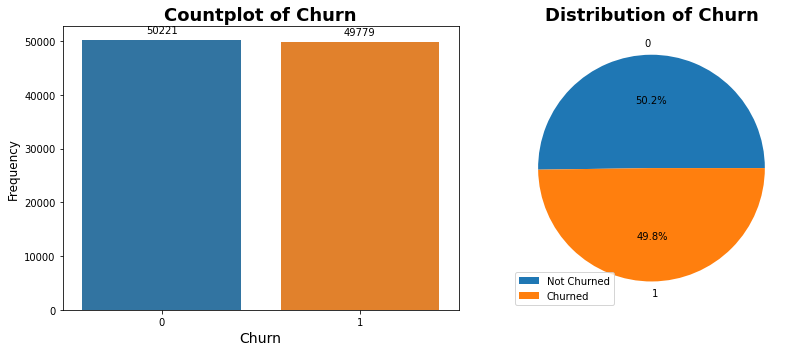

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Countplot
sns.countplot(data=data,
              x='Churn', 
              ax=axs[0])

axs[0].set_xlabel('Churn',fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=12)
axs[0].set_title('Countplot of Churn', fontsize=18, fontweight='bold')

# Annotation for countplot
for p in axs[0].patches:
    axs[0].annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., 
                     p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')

# Pie Chart
axs[1].set_title('Distribution of Churn', fontsize=18, fontweight='bold')
axs[1].pie(data['Churn'].value_counts(), 
           labels=data['Churn'].value_counts().index, 
           autopct='%1.1f%%')

legend_labels = ['Not Churned', 'Churned']
axs[1].legend(legend_labels, loc = 'best')


fig.tight_layout()
plt.show()

- Dataset is alomost balanced as both churn and not churn consist have roughly equal proprtion.

### 3.2 Histogram and Boxplot of Continous Features in Data

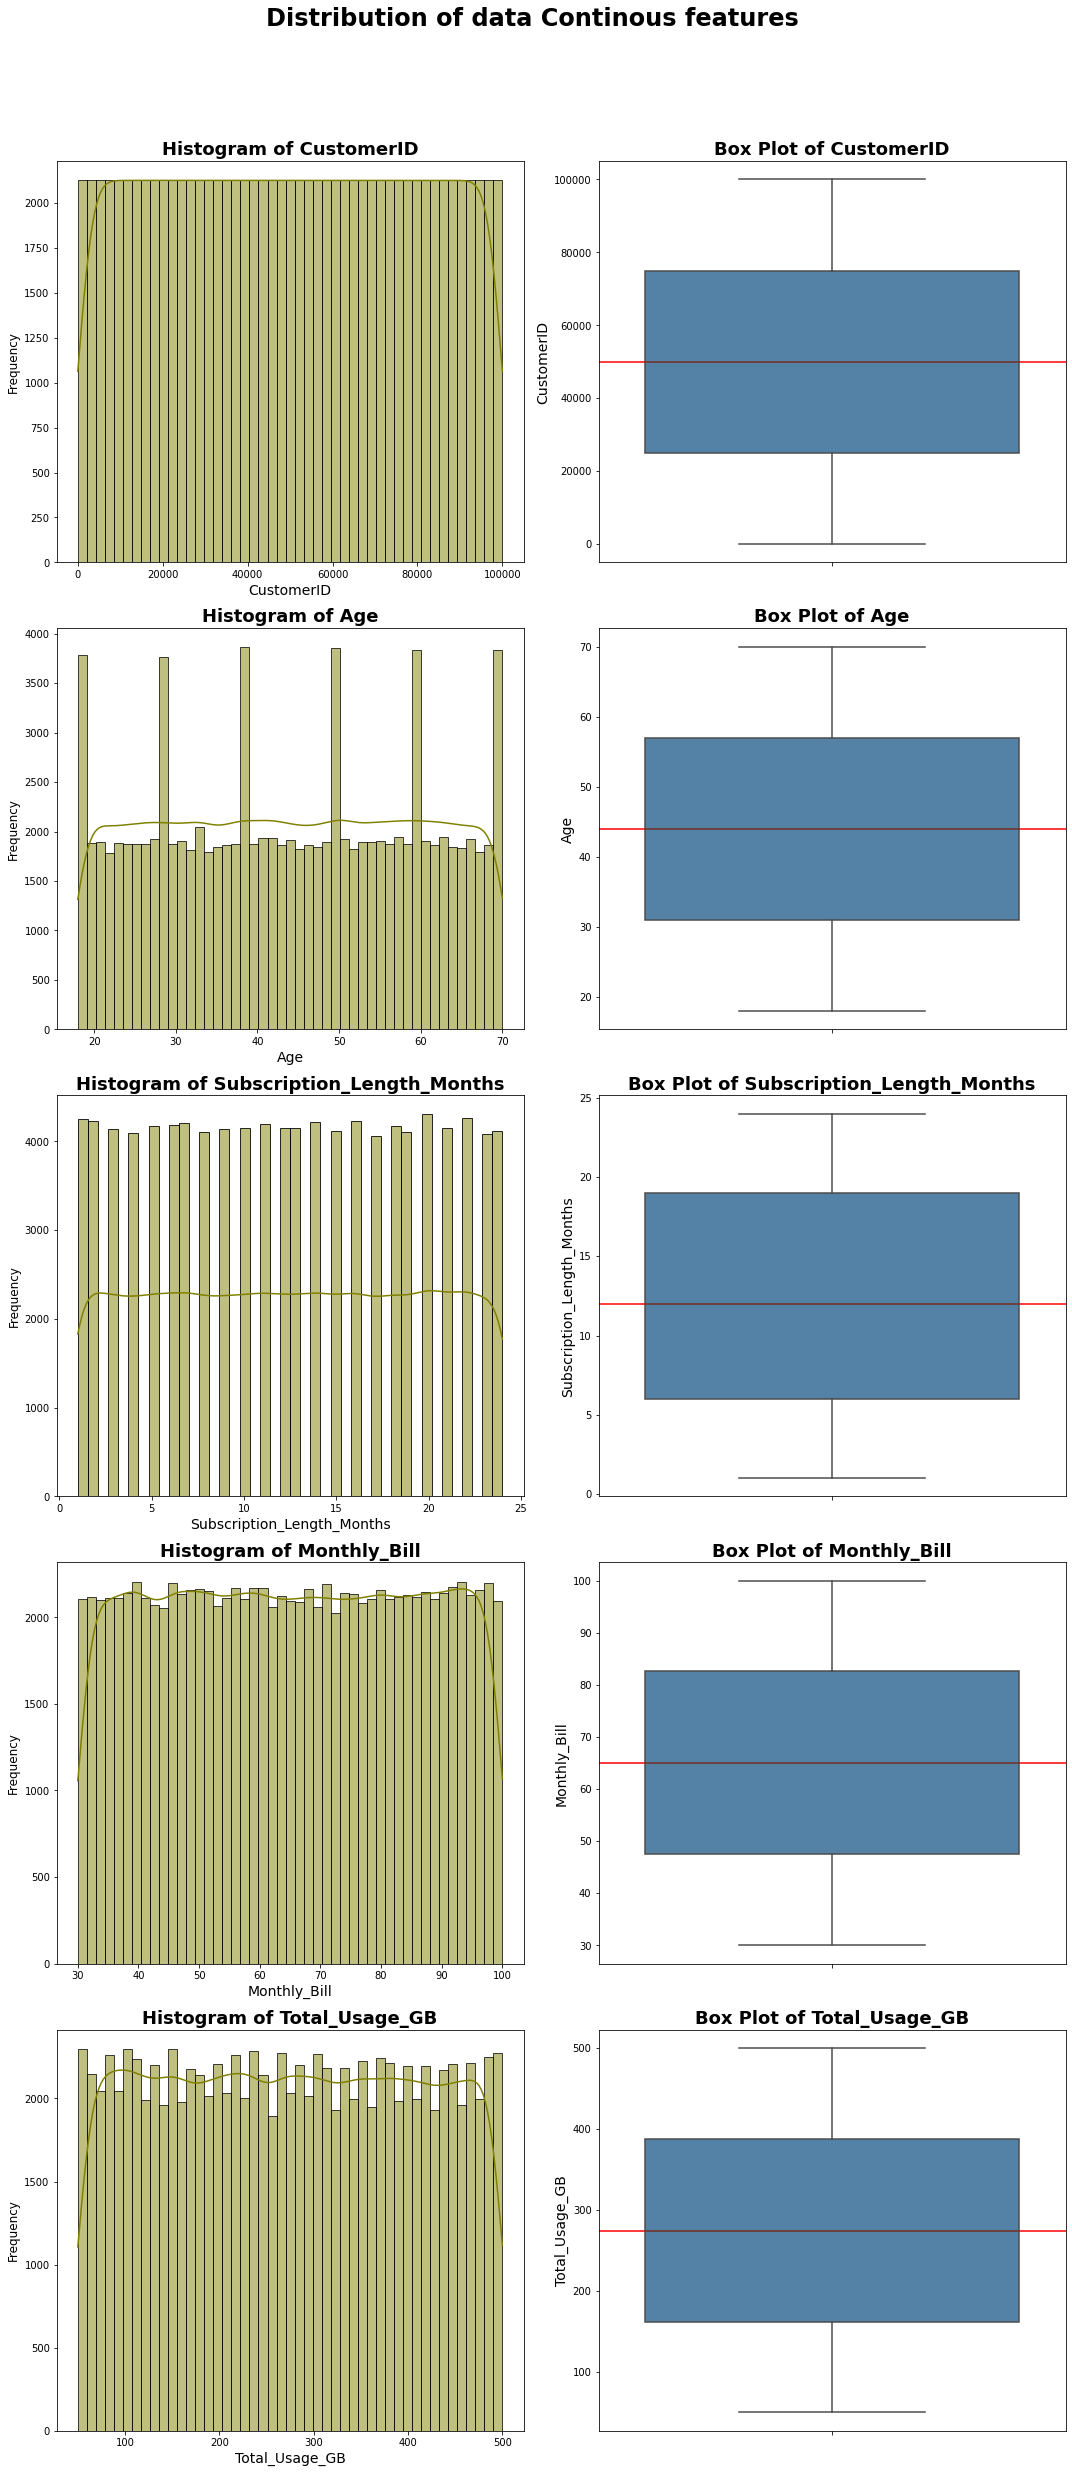

In [10]:
def plot_continous_features(df, cont_features, df_name, figsize=(15, 35)):
    n_rows = len(cont_features)
    n_cols = 2
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    axs = axs.flatten()


    for i, feature in enumerate(cont_features):
        sns.histplot(data=df, kde= True, x=feature, color="olive", ax=axs[2*i])
        axs[2*i].set_xlabel(feature, fontsize=14)
        axs[2*i].set_ylabel("Frequency", fontsize=12)
        axs[2*i].set_title("Histogram of " + feature, fontsize=18,  weight='bold') 
        
        # Plot the box plot on the right side
        sns.boxplot(data=df, y=feature,color= 'steelblue', ax=axs[2*i+1])
        axs[2*i+1].set_ylabel(feature, fontsize=14)
        axs[2*i+1].axhline(df[feature].median(), color="red")
        axs[2*i+1].set_title("Box Plot of " + feature, fontsize=18,  weight='bold')



    fig.suptitle(f"Distribution of {df_name} Continous features \n\n\n\n\n", fontsize=24, weight='bold')
    fig.tight_layout()
    plt.show()
    
    
    
num_features = list(data.columns[(data.dtypes != 'object') & (data.dtypes != 'datetime64[ns]') & (data.nunique() > 20)])
plot_continous_features(data,
                        num_features, 
                        df_name = 'data')

### 3.3 Barplot of Categorical Features

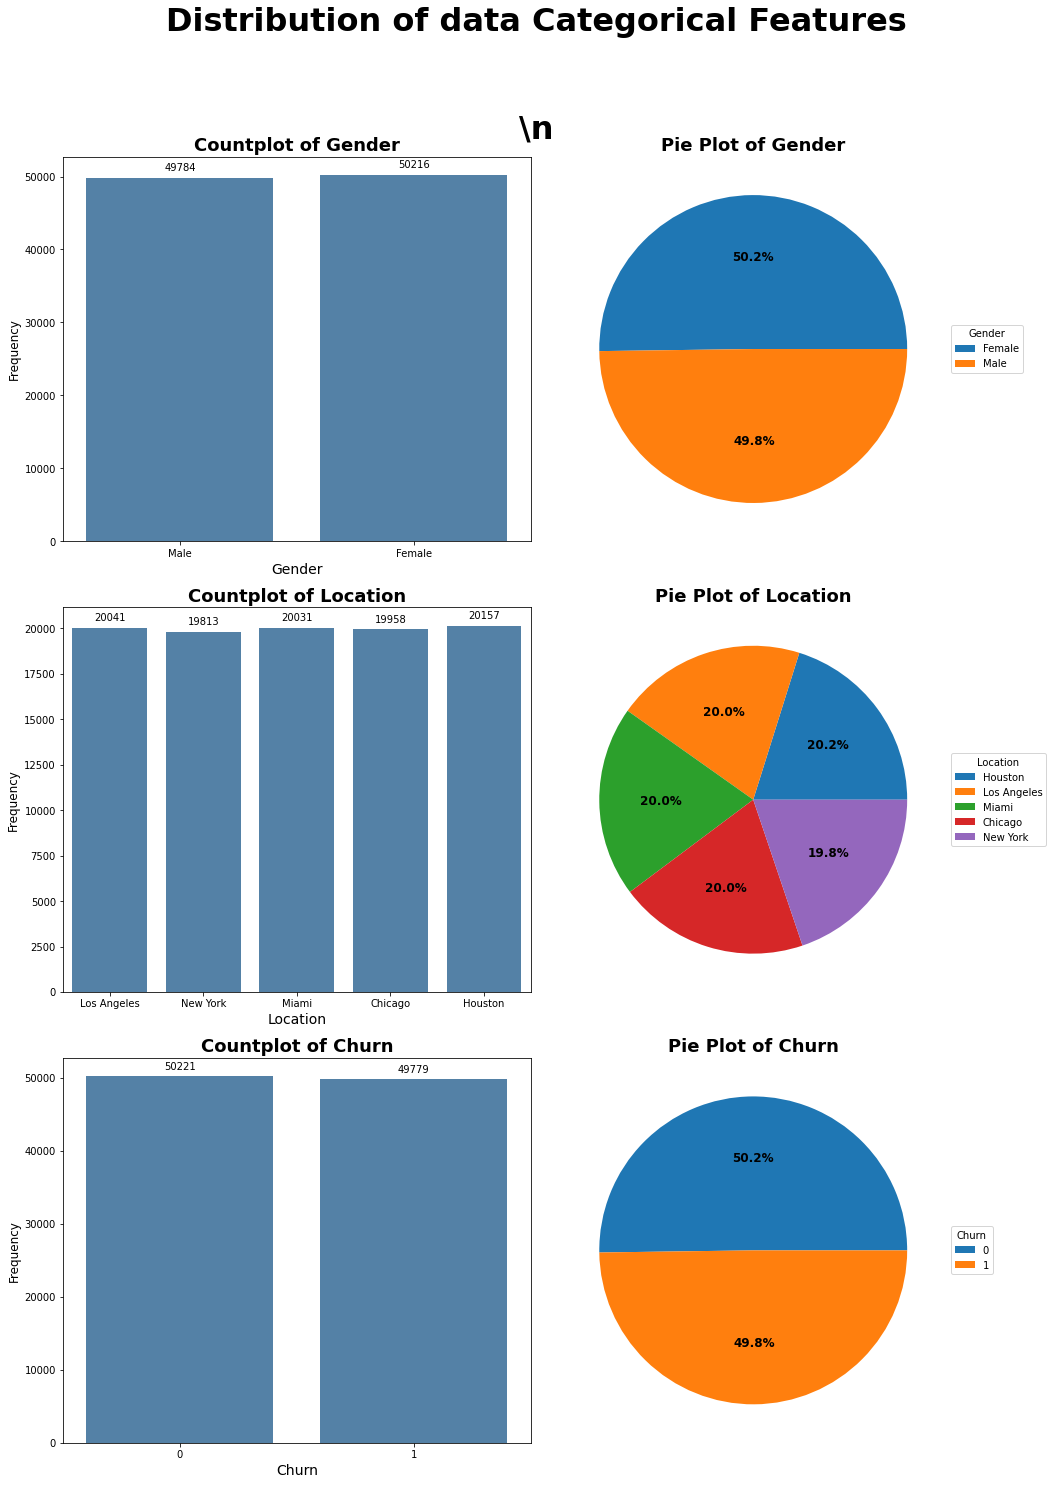

In [11]:
def piecat_plot(df, cat_features, df_name):
    n_rows = len(cat_features)
    n_cols = 2
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 7 * n_rows))
    axs = axs.flatten()

    for i, feature in enumerate(cat_features):
        # Countplot
        sns.countplot(data=df, x=feature, color="steelblue", ax=axs[2 * i])

        axs[2 * i].set_xlabel(feature, fontsize=14)
        axs[2 * i].set_ylabel('Frequency', fontsize=12)
        axs[2 * i].set_title(f'Countplot of {feature}', fontsize=18, fontweight='bold')

        # Annotation for countplot
        for p in axs[2 * i].patches:
            axs[2 * i].annotate(format(p.get_height(), '.0f'),
                                (p.get_x() + p.get_width() / 2., p.get_height()),
                                ha='center',
                                va='center',
                                xytext=(0, 10),
                                textcoords='offset points')

        # Pie Chart
        axs[2 * i + 1].set_title(f'Pie Plot of {feature}', fontsize=18, fontweight='bold')
        pie_data = df[feature].value_counts()
        wedges, _, autotexts = axs[2 * i + 1].pie(pie_data,
                                                  autopct='%1.1f%%')
        axs[2 * i + 1].legend(wedges, pie_data.index, title=feature, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
        plt.setp(autotexts, size=12, weight="bold")

    fig.suptitle(f"Distribution of {df_name} Categorical Features\n\n\n\\n", fontsize=32, weight='bold')
    fig.tight_layout()
    plt.show()

cat_features = list(data.columns[(data.nunique() < 20) & (data.dtypes != 'datetime64[ns]')])

piecat_plot(data,cat_features, df_name='data')

### 3.4 Correlation Between Numerical Features

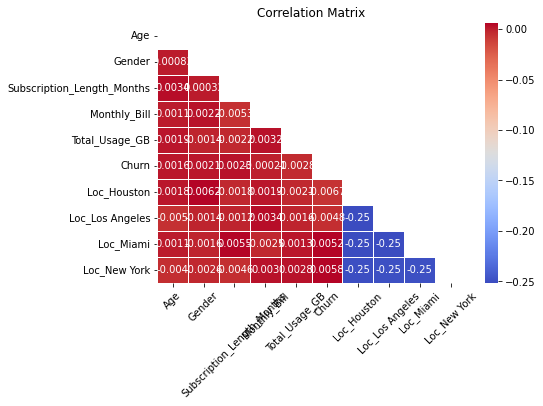

In [12]:
corr_matrix = encoded_dropped_df.corr(numeric_only=True)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, linewidths=0.5)

plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)


plt.tight_layout(pad=2)
plt.show()

- not much correlation between features 

# 4. Feature Engineering

### 4.1 Normalization

In [13]:
numerical_cols = ['Age', 'Subscription_Length_Months','Monthly_Bill', 'Total_Usage_GB'] 
scaled_encoded_dropped_df = encoded_dropped_df.copy()

scaler = StandardScaler()
scaled_encoded_dropped_df[numerical_cols] = scaler.fit_transform(encoded_dropped_df[numerical_cols])

## 5. Modelling

### 5.1 Pipeline 

In [14]:
def model_pipeline(classifier, data, k):
    target = data['Churn']
    data_X = data.drop(['Churn'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(data_X, target, test_size=0.3, random_state=42)

    pipeline = Pipeline([
        ('feature_selector', SelectKBest(score_func=f_classif, k=k)),
        ('classifier', classifier)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return pipeline, accuracy, f1

#### 5.1.1 Logistic Pipeline

In [15]:
logistic_classifier = LogisticRegression()
trained_pipeline, accuracy, f1 = model_pipeline(logistic_classifier, 
                                 scaled_encoded_dropped_df,
                                 5)
print(f"Accuracy : {accuracy}\nf1:{f1}")

Accuracy : 0.5018666666666667
f1:0.45312156920149305


#### 5.1.2 Random Forest Pipeline 

In [16]:
rf_classifier = RandomForestClassifier()
trained_pipeline, accuracy, f1 = model_pipeline(rf_classifier, 
                                                encoded_dropped_df,
                                                5)
print(f"Accuracy : {accuracy}\nf1:{f1}")

Accuracy : 0.4998
f1:0.4990652957671251


#### 5.1.3 Xgboost Pipeline

In [17]:

xgb_classifier = xgb.XGBClassifier(
    learning_rate=0.01,  
    n_estimators=100, 
    max_depth=3, 
    random_state=42
)

trained_pipeline, accuracy, f1 = model_pipeline(xgb_classifier, 
                                                encoded_dropped_df,
                                                5)
print(f"Accuracy : {accuracy}\nf1:{f1}")

Accuracy : 0.5004333333333333
f1:0.4271681382104499


## 5.2 Tuning Random Forest Model

In [18]:
target = encoded_dropped_df['Churn']
data_X = encoded_dropped_df.drop(['Churn'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(data_X, target, test_size=0.3, random_state=42)

In [19]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
feature_importances = rf_classifier.feature_importances_
feature_importances

array([0.19670803, 0.01675277, 0.13986873, 0.31577203, 0.29054121,
       0.00992693, 0.01059424, 0.01062969, 0.00920637])

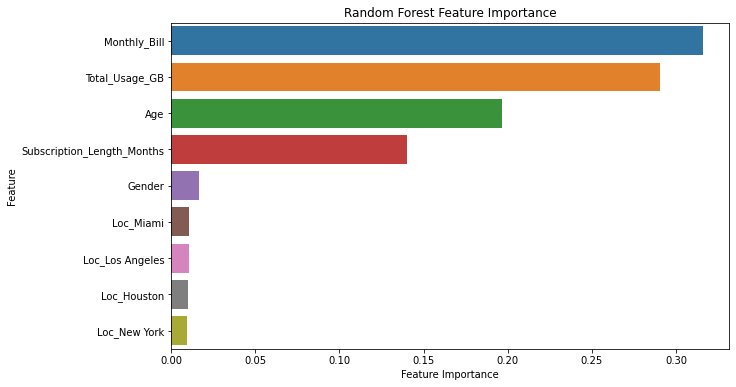

In [20]:
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()

### 5.2.1 Training with most important feature

In [21]:
top_n = 4
top_feature_indices = feature_importances.argsort()[-top_n:][::-1]

X_train_selected = X_train.iloc[:, top_feature_indices]
X_test_selected = X_test.iloc[:, top_feature_indices]

rf_classifier.fit(X_train_selected, y_train)
y_pred = rf_classifier.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy with selected features: {accuracy:.2f}')

Accuracy with selected features: 0.50


### 5.2.2 Tuning with GridSearchCV

In [23]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [1,5,10],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [24]:
best_rf_classifier = RandomForestClassifier(random_state=42, **best_params)
best_rf_classifier.fit(X_train_selected, y_train)

y_pred_best = best_rf_classifier.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred_best)
print(f'Best Model Accuracy: {accuracy:.2f}')
print(f'Best Hyperparameters: {best_params}')

Best Model Accuracy: 0.50
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


# 6. Saving Best Model

In [25]:
joblib.dump(best_rf_classifier, 'best_rf_classifier_model.pkl') 

['best_rf_classifier_model.pkl']